In [2]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from utils.metrics import evaluate
import pmdarima as pm
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt
from statsmodels.tsa.ar_model import AR
#!pip install pmdarima
#import pmdarima as pm #python 3.8 issue for pmdarima
from statsmodels.tsa.statespace.sarimax import SARIMAX
import warnings
warnings.filterwarnings('ignore')
from statsmodels.tsa.arima_model import ARMA, ARIMA

ModuleNotFoundError: No module named 'pmdarima'

,datetimeindex,pollution,dew,temperature,pressure,wind speed,snow,rain
0,2010-01-02,145.958333,-8.500000,-5.125000,1024.750000,24.860000,0.708333,0.0
1,2010-01-03,78.833333,-10.125000,-8.541667,1022.791667,70.937917,14.166667,0.0
2,2010-01-04,31.333333,-20.875000,-11.500000,1029.291667,111.160833,0.000000,0.0
3,2010-01-05,42.458333,-24.583333,-14.458333,1033.625000,56.920000,0.000000,0.0
4,2010-01-06,56.416667,-23.708333,-12.541667,1033.750000,18.511667,0.000000,0.0
...,...,...,...,...,...,...,...,...
1820,2014-12-27,238.666667,-9.666667,-1.791667,1027.833333,9.278333,0.000000,0.0
1821,2014-12-28,197.375000,-10.791667,1.583333,1019.958333,10.948750,0.000000,0.0
1822,2014-12-29,159.000000,-12.333333,0.750000,1013.750000,8.000000,0.000000,0.0
1823,2014-12-30,46.083333,-13.916667,1.875000,1019.125000,9.778333,0.000000,0.0


In [18]:
dataset = pd.read_csv('air_pollution.csv', parse_dates = ['datetimeindex'])
dataset["pollution_yesterday"] = (
        dataset["pollution"].tolist()[-1:]
        + dataset["pollution"].tolist()[:-1])
dataset.set_index('datetimeindex', inplace = True)
split_date = '2014-01-01'
training = dataset.loc[dataset.index <= split_date]
test = dataset.loc[dataset.index > split_date]
training.to_csv('training.csv')
test.to_csv('test.csv')

In [21]:
# Also add the naive mean average value
results = {}
prediction = {}
mean = training['pollution'].mean()
mean = np.array([mean for u in range(len(test))])
results['Naive mean'] = evaluate(test['pollution'], mean)
prediction['Naive mean'] = mean
results['Yesterdays value'] = evaluate(
    test['pollution'], test['pollution_yesterday'])
prediction['Yesterdays value'] = test['pollution_yesterday'].values

/Users/newuser/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/Users/newuser/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/holtwinters/model.py:427: FutureWarning: After 0.13 initialization must be handled at model creation
  warnings.warn(


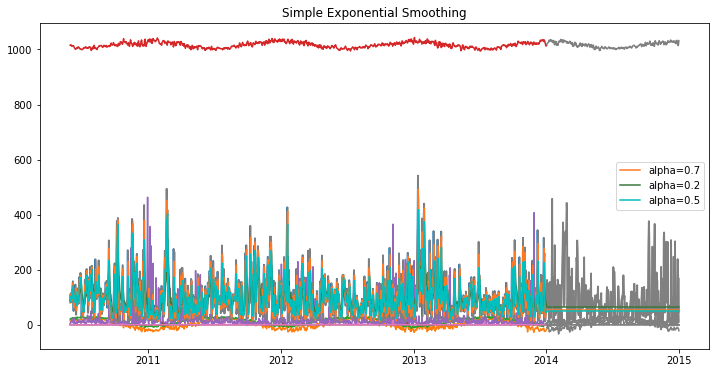

In [30]:
model = SimpleExpSmoothing(training['pollution'])
#model._index = pd.to_datetime(train.index)

fit1 = model.fit()
pred1 = fit1.forecast(364)
fit2 = model.fit(smoothing_level=.2)
pred2 = fit2.forecast(364)
fit3 = model.fit(smoothing_level=.5)
pred3 = fit3.forecast(364)

fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(training.index[150:], training.values[150:])
ax.plot(test.index, test.values, color="gray")
for p, f, c in zip((pred1, pred2, pred3),(fit1, fit2, fit3),('#ff7823','#3c763d','c')):
    ax.plot(training.index[150:], f.fittedvalues[150:], color=c)
    ax.plot(test.index, p, label="alpha="+str(f.params['smoothing_level'])[:3], color=c)
plt.title("Simple Exponential Smoothing")    
plt.legend();

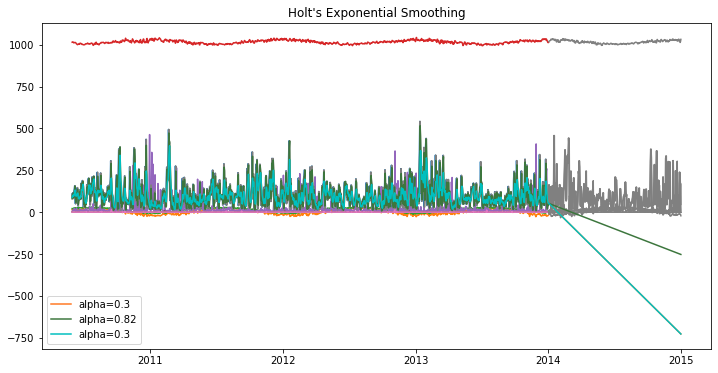

In [56]:
#Holt Winters Exponential Smoothing
model = Holt(np.asarray(training['pollution']))
#model._index = pd.to_datetime(train.index)

fit1 = model.fit(smoothing_level=.3)
pred1 = fit1.forecast(len(test['pollution']))
fit2 = model.fit(optimized=True)
pred2 = fit2.forecast(len(test['pollution']))
fit3 = model.fit(smoothing_level=.3)
pred3 = fit3.forecast(len(test['pollution']))

fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(training.index[150:], training.values[150:])
ax.plot(test.index, test.values, color="gray")
for p, f, c in zip((pred1, pred2, pred3),(fit1, fit2, fit3),('#ff7823','#3c763d','c')):
    ax.plot(training.index[150:], f.fittedvalues[150:], color=c)
    ax.plot(test.index, p, label="alpha="+str(f.params['smoothing_level'])[:4], color=c)
plt.title("Holt's Exponential Smoothing")
plt.legend();

In [83]:
#AR Model
temp_train = dataset[:len(dataset)-365]
autoregression = ARMA(temp_train['pollution'], order = (1,0))
ar = autoregression.fit()
print(ar.summary())



                              ARMA Model Results                              
Dep. Variable:              pollution   No. Observations:                 1460
Model:                     ARMA(1, 0)   Log Likelihood               -8105.557
Method:                       css-mle   S.D. of innovations             62.345
Date:                Sat, 05 Jun 2021   AIC                          16217.114
Time:                        00:50:15   BIC                          16232.973
Sample:                    01-02-2010   HQIC                         16223.030
                         - 12-31-2013                                         
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
const              98.3198      3.751     26.214      0.000      90.969     105.671
ar.L1.pollution     0.5654      0.022     26.205      0.000       0.523       0.608
                                

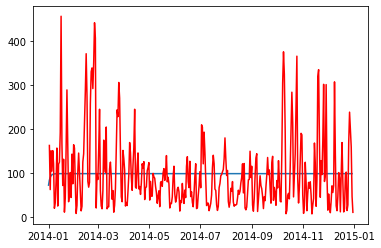

In [85]:
# Make the predictions
pred = ar.predict(start=len(temp_train), end=len(temp_train) + len(test)-1, dynamic=False)
# Plot the prediction vs test data
plt.plot(pred)
plt.plot(test['pollution'], color='red')

In [64]:
index = len(training)
yhat = list()
for t in tqdm(range(len(test['pollution']))):
    temp_train = dataset[:len(training)+t]
    model = AR(temp_train['pollution'])
    model_fit = model.fit()
    predictions = model_fit.predict(
        start=len(temp_train), end=len(temp_train), dynamic=False)
    yhat = yhat + [predictions]

yhat = pd.concat(yhat)
results['AR'] = evaluate(test['pollution'], yhat.values)
prediction['AR'] = yhat.values

100%|██████████| 364/364 [00:03<00:00, 97.60it/s] 


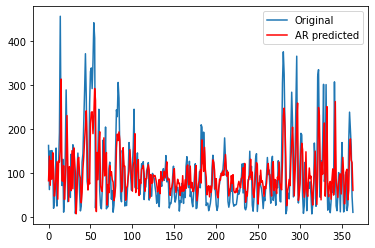

In [65]:
plt.plot(test['pollution'].values, label='Original')
plt.plot(yhat.values, color='red', label='AR predicted')
plt.legend()

In [73]:
#ARMA Model
index = len(training)
yhat = list()
for t in tqdm(range(len(test['pollution']))):
    temp_train = dataset[:len(training)+t]
    model = ARMA(temp_train['pollution'],order = (1,1))
    model_fit = model.fit()
    predictions = model_fit.predict(
        start=len(temp_train), end=len(temp_train), dynamic=False)
    yhat = yhat + [predictions]

yhat = pd.concat(yhat)
results['ARMA'] = evaluate(test['pollution'], yhat.values)
prediction['ARMA'] = yhat.values

100%|██████████| 364/364 [01:26<00:00,  4.22it/s]


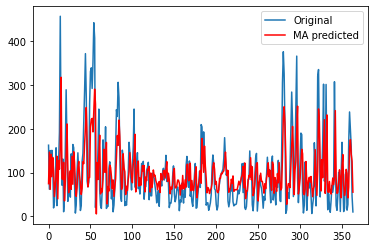

In [77]:
plt.plot(test['pollution'].values, label='Original')
plt.plot(yhat.values, color='red', label='ARMA predicted')
plt.legend()

In [81]:
index = len(training)
yhat = list()
for t in tqdm(range(len(test['pollution']))):
    temp_train = dataset[:len(training)+t]
    model = ARMA(temp_train['pollution'],order = (1,1))
    model_fit = model.fit()
    predictions = model_fit.predict(
        start=len(temp_train), end=len(temp_train), dynamic=False)
    yhat = yhat + [predictions]

yhat = pd.concat(yhat)
results['MA'] = evaluate(test['pollution'], yhat.values)
prediction['MA'] = yhat.values

100%|██████████| 364/364 [01:26<00:00,  4.21it/s]


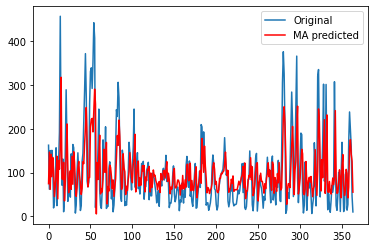

In [82]:
plt.plot(test['pollution'].values, label='Original')
plt.plot(yhat.values, color='red', label='MA predicted')
plt.legend()

In [87]:
index = len(training)
yhat = list()
for t in tqdm(range(len(test['pollution']))):
    temp_train = dataset[:len(training)+t]
    model = ARIMA(temp_train['pollution'],order = (1,0,0))
    model_fit = model.fit()
    predictions = model_fit.predict(
        start=len(temp_train), end=len(temp_train), dynamic=False)
    yhat = yhat + [predictions]

yhat = pd.concat(yhat)
results['ARIMA'] = evaluate(test['pollution'], yhat.values)
prediction['ARIMA'] = yhat.values

100%|██████████| 364/364 [00:28<00:00, 12.85it/s]


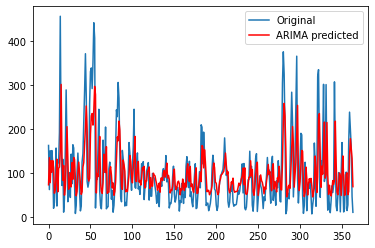

In [89]:
plt.plot(test['pollution'].values, label='Original')
plt.plot(yhat.values, color='red', label='ARIMA predicted')
plt.legend()

In [100]:
index = len(training)
yhat = list()
for t in tqdm(range(len(test['pollution']))):
    temp_train = dataset[:len(training)+t]
    model = SARIMAX(temp_train['pollution'],order = (1,0,0), seasonal_order = (0,0,0,3))
    model_fit = model.fit()
    predictions = model_fit.predict(
        start=len(temp_train), end=len(temp_train), dynamic=False)
    yhat = yhat + [predictions]

yhat = pd.concat(yhat)
results['ARIMA'] = evaluate(test['pollution'], yhat.values)
prediction['ARIMA'] = yhat.values

100%|██████████| 364/364 [00:30<00:00, 12.07it/s]


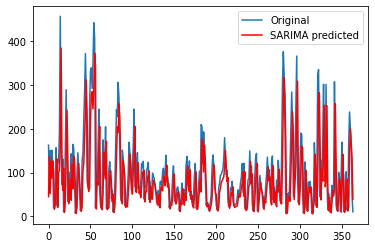

In [102]:
plt.plot(test['pollution'].values, label='Original')
plt.plot(yhat.values, color='red', label='SARIMA predicted')
plt.legend()

In [1]:
autoModel = pm.auto_arima(training['pollution'], trace=True, error_action='ignore',
                          suppress_warnings=True, seasonal=True, m=6, stepwise=True)
autoModel.fit(training['pollution_today'])


NameError: name 'pm' is not defined